The dataset for this BINARY CLASSIFIER to be used is [bc-dataset.csv].
There are 2 implementations here:
1. **Bag of words approach.**
2. Word vectors (can be pre-trained word embeddings).

The dataset split is 60-40.
Evaluation metrics to be used in this are:
1. Precision.
2. Recall.
3. F-Measure.

Loads the dataset.

In [1]:
from ftfy import fix_encoding
import pandas as pd
import numpy as np
import re
import csv
import string 
import nltk as nlp
from nltk.corpus import stopwords

nlp.download("stopwords")
nlp.download('punkt')
nlp.download('wordnet')

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def fix_encode(x):
    return fix_encoding(x)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv(
    "datasets/bc-dataset.csv",
    encoding="latin1",
    sep=",",
    quoting=csv.QUOTE_ALL
)

data = pd.concat([df.gender, df['gender:confidence'], df.description], axis=1)

#drop null rows
data.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(20050, 3)

# DATA PREPROCESSING

This section does the following:
1. Drops any rows containing NaN values in either the *description* or *gender* column.
2. Drops any rows containing the string 'brand' in *gender*.
3. Drops any rows containing values < **0.80** in the *gender:confidence* columm.
4. Resets the index.

In [2]:
data.dropna(subset=['description', 'gender'], inplace=True)
data = data.reset_index(drop=True)

data.drop(data[data['gender'] == 'brand'].index, inplace=True)
data = data.reset_index(drop=True)

data.drop(data[data['gender:confidence'] < 0.80].index, inplace=True)
data.drop('gender:confidence', axis=1, inplace=True)
data = data.reset_index(drop=True)

data.shape

(8847, 2)

Get the rows for *male* and *female* genders.

This section does the following to the text:
1. Fixes any broken encoding (via *ftfy*) that might have occurred when loading the file.
2. Removes the URL.
3. Removes HTML tags.
4. Removes emojis.
5. Removes punctuation.

In [3]:
data.description = data.description.apply(lambda x: fix_encode(x))

data['description']=data['description'].apply(lambda x : remove_URL(x))
data['description']=data['description'].apply(lambda x : remove_html(x))
data['description']=data['description'].apply(lambda x : remove_emoji(x))
data['description']=data['description'].apply(lambda x : remove_punct(x))
data.shape

(8847, 2)

In [4]:
print("ORIGINAL: ", data.description.iloc[5211])

ORIGINAL:  Owner of Itty Bitty the Pitty Scholar Writer Activist Unapologetic Fat Lady 


Converts all instances of female into value 0, and 1 for male.

In [5]:
data.gender = [0 if gender == 'female' else 1 for gender in data.gender]

data['gender'].value_counts(ascending=True)

1    4227
0    4620
Name: gender, dtype: int64

In [88]:
description_list = []

for each in data.description:
    each = re.sub("[^a-zA-Z]"," ", str(each))                                        
    each = each.lower()                                                              
    each = nlp.word_tokenize(each)                                                   
    each = [word for word in each if not word in set(stopwords.words("english"))]    
    each = [lemma.lemmatize(word) for word in each]                                  
    each = " ".join(each)                                                           
    # each = correct_spellings(each)                                                   # correct the spelling (?)
    description_list.append(each)                                                    

data.shape

(8847, 2)

(8847, 2)

In [6]:
lemma = nlp.WordNetLemmatizer()

In [45]:
data_female = data[data.gender == 0]
data_male = data[data.gender == 1]

In [8]:
description_list_female = []

for each in data_female.description:
    each = re.sub("[^a-zA-Z]"," ", str(each))                                        
    each = each.lower()                                                              
    each = nlp.word_tokenize(each)                                                   
    each = [word for word in each if not word in set(stopwords.words("english"))]    
    each = [lemma.lemmatize(word) for word in each]                                  
    each = " ".join(each)                                                           
    # each = correct_spellings(each)                                                   # correct the spelling (?)
    description_list_female.append(each)                                                    

data_female.shape

(4620, 2)

In [9]:
lemma = nlp.WordNetLemmatizer()

In [10]:
description_list_male = []

for each in data_male.description:
    each = re.sub("[^a-zA-Z]"," ", str(each))                                        
    each = each.lower()                                                              
    each = nlp.word_tokenize(each)                                                   
    each = [word for word in each if not word in set(stopwords.words("english"))]    
    each = [lemma.lemmatize(word) for word in each]                                  
    each = " ".join(each)                                                           
    # each = correct_spellings(each)                                                   # correct the spelling (?)
    description_list_male.append(each)                                                    

data_male.shape

(4227, 2)

In [12]:
print(len(description_list_male))
print(len(description_list_female))

4227
4620


In [13]:
print("ORIGINAL: ", data.description.iloc[5232])
print("PREPROCESSED: ", description_list_male[3232])
print("PREPROCESSED: ", description_list_female[3232])

ORIGINAL:  We are all Stardust
PREPROCESSED:  breath fresh air
PREPROCESSED:  greek directioner zquad mixer hope one member one direction little mix zayn malik follow


**WARNING: DO NOT RUN MORE THAN ONCE.**

# MODEL BUILDING

Uses ```CountVectorizer()``` to implement Bag-of-Words. The ``MAX_FEATURES`` variable determines the maximum number of features to be used during implementation.

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

MAX_FEATURES = 3000

# print(data_female.shape)
# print(data_male.shape)

bow_female = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')
sm_female = bow_female.fit_transform(description_list_female).toarray()
words_female = bow_female.get_feature_names()


bow_male = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')
sm_male = bow_male.fit_transform(description_list_male).toarray()
words_male = bow_male.get_feature_names()

In [104]:
print(sm_female.shape)

(4620, 3000)


In [105]:
print(words_female[250:300])
print(words_male[250:300])

['born', 'bound', 'bout', 'boutique', 'box', 'boy', 'boyfriend', 'brain', 'brand', 'branding', 'brave', 'break', 'breakfast', 'breast', 'breath', 'breathe', 'bring', 'brings', 'bristol', 'british', 'bro', 'broadway', 'broken', 'brother', 'brownie', 'bts', 'btw', 'buff', 'build', 'builder', 'bum', 'burn', 'burning', 'business', 'busy', 'butter', 'butterfly', 'button', 'buy', 'bye', 'ca', 'caffeine', 'cairo', 'cake', 'caleb', 'cali', 'california', 'called', 'calm', 'calum']
['bright', 'brighter', 'brilliant', 'bring', 'bringing', 'brit', 'british', 'bro', 'broadcast', 'broadcaster', 'broadcasting', 'broken', 'broker', 'bronco', 'bros', 'brother', 'brown', 'bruce', 'bruin', 'bs', 'buckeye', 'buff', 'buffalo', 'build', 'builder', 'building', 'bull', 'bullshit', 'bus', 'business', 'busy', 'button', 'buy', 'buyer', 'buying', 'buzzfeed', 'ca', 'calgary', 'california', 'called', 'came', 'camera', 'campaign', 'canada', 'canadian', 'cancer', 'candidate', 'cap', 'cape', 'capital']


In [106]:
sparse_matrix_concat = np.concatenate((sm_female, sm_male))

In [107]:
sparse_matrix_concat.shape

(8847, 3000)

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer

MAX_FEATURES = 3000

bag_of_words = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')
sparse_matrix = bag_of_words.fit_transform(description_list).toarray()
words = bag_of_words.get_feature_names()

# sparse_matrix = list(dict.fromkeys(sparse_matrix))

sparse_matrix.shape

(8847, 3000)

In [109]:
print(words[250:300])

['bitcoin', 'bite', 'bitter', 'biz', 'black', 'blacklivesmatter', 'blah', 'blame', 'bleed', 'bless', 'blessed', 'blessing', 'blind', 'block', 'blocked', 'blog', 'blogger', 'blogging', 'blonde', 'blood', 'blow', 'blue', 'bluelivesmatter', 'blunt', 'board', 'bob', 'body', 'bodybuilder', 'boise', 'bold', 'bone', 'book', 'booking', 'border', 'boring', 'born', 'bos', 'boston', 'bot', 'bound', 'bout', 'boutique', 'bowl', 'box', 'boxing', 'boy', 'boyfriend', 'brain', 'brand', 'branding']


The train-test split is 60-40.

THE ONE WITH CONCATED SPARSE MATRICES

In [110]:
from sklearn.model_selection import train_test_split

X = sparse_matrix_concat
y = data.gender.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

THE ORIGINAL ONE.

In [119]:
from sklearn.model_selection import train_test_split

X = sparse_matrix
y = data.gender.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

# TRAINING & EVALUATION

In [111]:
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

## Random Forest Classifier

In [62]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [63]:
# mean accuracy
rfc.score(X_test, y_test)

0.6385984741452387

In [64]:
# y pred
y_pred_rfc = rfc.predict(X_test)

In [65]:
cm = confusion_matrix(y_test, y_pred_rfc)

f_measure = f1_score(y_test, y_pred_rfc, average="weighted")
precision_measure = precision_score(y_test, y_pred_rfc, average="weighted")
recall_measure = recall_score(y_test, y_pred_rfc, average="weighted")

print(classification_report(y_test, y_pred_rfc, digits=5))
print("F1 Score:", f_measure*100)
print("Precision:", precision_measure*100)
print("Recall:", recall_measure*100)


              precision    recall  f1-score   support

           0    0.64657   0.70272   0.67347      1877
           1    0.62775   0.56619   0.59538      1662

    accuracy                        0.63860      3539
   macro avg    0.63716   0.63445   0.63443      3539
weighted avg    0.63773   0.63860   0.63680      3539

F1 Score: 63.68000533375526
Precision: 63.77318063741676
Recall: 63.85984741452388


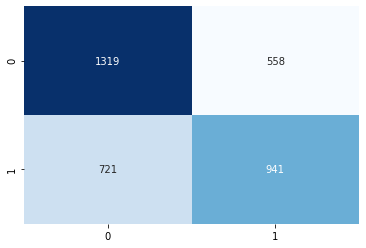

In [66]:
# for confusion matrix
sns.heatmap(cm, cbar=False, annot=True, cmap="Blues", fmt="d")
plt.show()

## Naive Bayes Model

### Multinomial NB

In [120]:
from collections import defaultdict
# from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB


nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)


f_measure_nb = f1_score(y_test, y_pred_nb, average="weighted")
precision_measure_nb = precision_score(y_test, y_pred_nb, average="weighted")
recall_measure_nb = recall_score(y_test, y_pred_nb, average="weighted")


print(classification_report(y_test, y_pred_nb, digits=5))
print("Mean accuracy: ", nb.score(X_test, y_test))
print("F-measure: ", f_measure_nb)
print("Precision: ", precision_measure_nb)
print("Recall: ", recall_measure_nb)


              precision    recall  f1-score   support

           0    0.64453   0.77851   0.70521      1833
           1    0.69358   0.53869   0.60640      1706

    accuracy                        0.66290      3539
   macro avg    0.66906   0.65860   0.65581      3539
weighted avg    0.66818   0.66290   0.65758      3539

Mean accuracy:  0.6628991240463408
F-measure:  0.6575801309304738
Precision:  0.6681797395815476
Recall:  0.6628991240463408


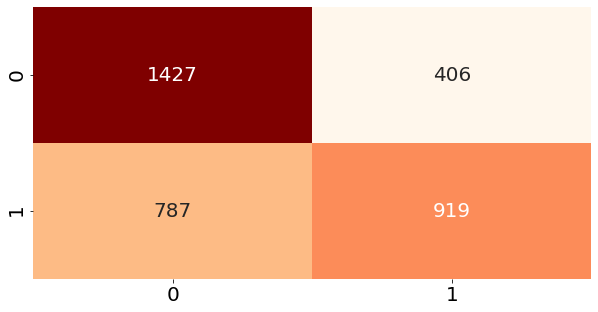

In [121]:
cm = confusion_matrix(y_test, y_pred_nb)
# for confusion matrix
sns.heatmap(cm, cbar=False, annot=True, cmap="OrRd", fmt="d")
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['font.size'] = 20
plt.show()

In [122]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

eval_scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

# 5-fold cross validation
cv = StratifiedKFold(
                n_splits = 5,
                shuffle=True,
                random_state=101
                )

mnb_scores = cross_validate(nb, X_train, y_train, cv=cv, scoring=eval_scoring, verbose=1)
print(mnb_scores)
print("------ incase i need it ------")
print("Mean Accuracy: ", np.mean(mnb_scores['test_accuracy']))
print("Mean F1 Score: ", np.mean(mnb_scores['test_f1_score']))
print("Mean Precision: ", np.mean(mnb_scores['test_precision']))
print("Mean Recall: ", np.mean(mnb_scores['test_recall']))

print("------ incase i need it ------")
print("Max Accuracy: ", max(mnb_scores['test_accuracy']))
print("Max F1 Score: ", max(mnb_scores['test_f1_score']))
print("Max Precision: ", max(mnb_scores['test_precision']))
print("Max Recall: ", max(mnb_scores['test_recall']))



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'fit_time': array([0.09873462, 0.07877517, 0.08776712, 0.06881809, 0.0767324 ]), 'score_time': array([0.01097059, 0.01097322, 0.00897408, 0.00897455, 0.00801897]), 'test_accuracy': array([0.66572505, 0.65819209, 0.60734463, 0.67200754, 0.6531574 ]), 'test_precision': array([0.68939394, 0.67070218, 0.61357702, 0.69897959, 0.67435897]), 'test_recall': array([0.54059406, 0.54960317, 0.46626984, 0.54365079, 0.5218254 ]), 'test_f1_score': array([0.60599334, 0.60414395, 0.52987599, 0.61160714, 0.58836689])}
------ incase i need it ------
Mean Accuracy:  0.6512853417963723
Mean F1 Score:  0.587997461619325
Mean Precision:  0.6694023416530197
Mean Recall:  0.5243886531510293
------ incase i need it ------
Max Accuracy:  0.6720075400565504
Max F1 Score:  0.6116071428571429
Max Precision:  0.6989795918367347
Max Recall:  0.5496031746031746


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


### Gaussian NB

In [123]:
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)
y_pred_gnb = gnb_classifier.predict(X_test)

print(classification_report(y_test, y_pred_gnb, digits=5))
print("Mean accuracy: ", gnb_classifier.score(X_test, y_test))
print("WEIGHTED F-measure: ", f1_score(y_test, y_pred_gnb, average="weighted"))
print("WEIGHTED Precision: ", precision_score(y_test, y_pred_gnb, average="weighted"))
print("WEIGHTED Recall: ", recall_score(y_test, y_pred_gnb, average="weighted"))

              precision    recall  f1-score   support

           0    0.60664   0.76814   0.67790      1833
           1    0.65107   0.46483   0.54241      1706

    accuracy                        0.62193      3539
   macro avg    0.62885   0.61648   0.61015      3539
weighted avg    0.62805   0.62193   0.61259      3539

Mean accuracy:  0.6219270980502967
WEIGHTED F-measure:  0.6125853827378143
WEIGHTED Precision:  0.6280539528586724
WEIGHTED Recall:  0.6219270980502967


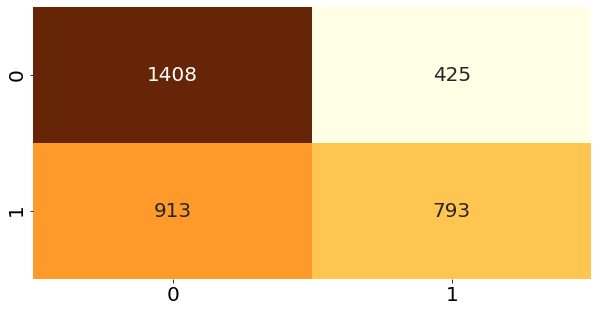

In [124]:
cm = confusion_matrix(y_test, y_pred_gnb)
# for confusion matrix
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['font.size'] = 20
sns.heatmap(cm, cbar=False, annot=True, cmap="YlOrBr", fmt="d")
plt.show()

## Logistic Regression

In [125]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

f_measure_lr = f1_score(y_test, y_pred_lr, average="weighted")
precision_measure_lr = precision_score(y_test, y_pred_lr, average="weighted")
recall_measure_lr = recall_score(y_test, y_pred_lr, average="weighted")

print(classification_report(y_test, y_pred_lr, digits=5))
print("Mean accuracy: ", lr.score(X_test, y_test))
print("F-measure: ", f_measure_lr)
print("Precision: ", precision_measure_lr)
print("Recall: ", recall_measure_lr)

              precision    recall  f1-score   support

           0    0.64442   0.76923   0.70132      1833
           1    0.68690   0.54396   0.60713      1706

    accuracy                        0.66064      3539
   macro avg    0.66566   0.65660   0.65422      3539
weighted avg    0.66490   0.66064   0.65591      3539

Mean accuracy:  0.6606385984741452
F-measure:  0.6559146154941223
Precision:  0.6648992466834098
Recall:  0.6606385984741452


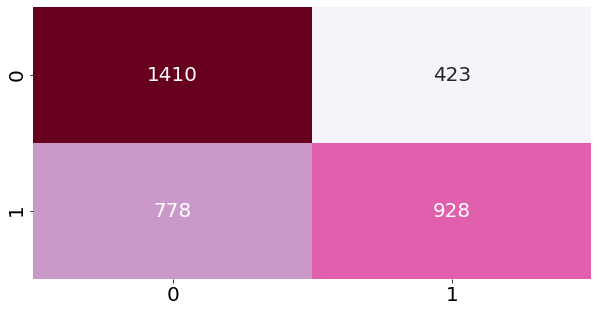

In [126]:
cm = confusion_matrix(y_test, y_pred_lr)
# for confusion matrix
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['font.size'] = 20
sns.heatmap(cm, cbar=False, annot=True, cmap="PuRd", fmt="d")
plt.show()

## Support Vector Machines

In [79]:
SVM = SVC(C=1.0, 
        kernel='sigmoid',
        degree=3,
        gamma='auto')
SVM.fit(X_train,y_train)
y_pred_svm = SVM.predict(X_test)

f_measure_svm = f1_score(y_test, y_pred_svm, average="weighted", labels=np.unique(y_pred_svm))
precision_measure_svm = precision_score(y_test, y_pred_svm, average="weighted", )
recall_measure_svm = recall_score(y_test, y_pred_svm, average="weighted", )

print(classification_report(y_test, y_pred_svm, digits=5))
print("Mean accuracy: ", SVM.score(X_test, y_test))
print("F-measure: ", f_measure_svm)
print("Precision: ", precision_measure_svm)
print("Recall: ", recall_measure_svm)

C:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

              precision    recall  f1-score   support

           0    0.53038   1.00000   0.69313      1877
           1    0.00000   0.00000   0.00000      1662

    accuracy                        0.53038      3539
   macro avg    0.26519   0.50000   0.34657      3539
weighted avg    0.28130   0.53038   0.36762      3539

Mean accuracy:  0.5303758123763775
F-measure:  0.6931314623338257
Precision:  0.2812985023539024
Recall:  0.5303758123763775
